# 🧠 Notebook 04: Model Training

**Objetivo:** Treinar modelo LSTM para predição de preços de ações

**Etapas:**
1. Criar sequências temporais (lookback window)
2. Split treino/validação/teste (ordem temporal)
3. Configurar DataLoaders PyTorch
4. Configurar GPU
5. Treinar modelo com early stopping
6. Salvar checkpoints
7. Visualizar resultados
8. Registrar experimentos

**Autor:** Tech Challenge Phase 4  
**Data:** 2025

In [64]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import json
import os
from datetime import datetime
import time
import warnings
import plotly.graph_objects as go
warnings.filterwarnings('ignore')

# Import custom model
import sys
sys.path.append('..')
from src.models.lstm_model import LSTMModel, LSTMTrainer

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 10

print("✅ All libraries imported successfully")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

✅ All libraries imported successfully
PyTorch version: 2.9.0+cu126
CUDA available: True


In [65]:
# Load normalized data
data_path = '../data/processed/df_normalized.csv'
df = pd.read_csv(data_path, index_col=0, parse_dates=True)
lookback = 60  # Must match training lookback


In [66]:
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'day_of_week', 'month_sin',
       'month_cos'],
      dtype='object')

In [67]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

def create_sequences(df, lookback=60, target_col='Close'):
    """
    Cria sequências temporais para LSTM com normalização MinMax.
    """
    # Seleciona colunas numéricas
    df_numeric = df.select_dtypes(include=[float, int])

    # Features e alvo
    feature_cols = [col for col in df_numeric.columns if col != target_col]
    target = df_numeric[target_col].values

    X, y = [], []
    for i in range(lookback, len(df_numeric)):
        X.append(df_numeric[feature_cols].iloc[i-lookback:i].values)
        y.append(target[i])

    X = np.array(X)
    y = np.array(y).reshape(-1, 1)
    
    return X, y, feature_cols


In [68]:
X, y, feature_cols = create_sequences(df, lookback)

In [69]:
import matplotlib.pyplot as plt

def plot_example_sequence(df, lookback=60, target_col="Close", example_idx=100):
    """
    Plota uma sequência de entrada e o valor alvo correspondente (para LSTM).
    
    Parâmetros
    -----------
    df : pd.DataFrame
        DataFrame com colunas ['Open', 'High', 'Low', 'Close', 'Volume'] (ou subset)
    lookback : int
        Número de dias anteriores usados como entrada
    target_col : str
        Nome da coluna alvo (ex: 'Close')
    example_idx : int
        Índice do exemplo para visualizar
    """

    if target_col not in df.columns:
        raise ValueError(f"Coluna '{target_col}' não encontrada no DataFrame.")

    if example_idx < lookback or example_idx >= len(df):
        raise IndexError(f"example_idx deve estar entre {lookback} e {len(df)-1}.")

    # Cria a sequência e o alvo
    seq = df[target_col].iloc[example_idx - lookback:example_idx]
    target = df[target_col].iloc[example_idx]

    plt.figure(figsize=(14, 5))
    plt.plot(range(lookback), seq, 'b-', linewidth=2, label='Input (últimos 60 dias)')
    plt.axhline(y=target, color='r', linestyle='--', linewidth=2, label=f'Target (dia seguinte): {target:.4f}')
    plt.scatter(lookback - 1, seq.iloc[-1], color='blue', s=100, zorder=5, label='Último dia do input')

    plt.title(f'Sequência #{example_idx}', fontsize=14, fontweight='bold')
    plt.xlabel('Dias (janela de lookback)')
    plt.ylabel('Preço (normalizado ou real)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    print(f"\nInput (primeiros 5 dias):\n{seq.head().values}")
    print(f"Target (próximo dia): {target:.6f}")


In [70]:
def split_and_scale(X, y, train_ratio=0.7, val_ratio=0.15):
    n_samples = len(X)
    train_size = int(n_samples * train_ratio)
    val_size = int(n_samples * val_ratio)

    X_train = X[:train_size]
    y_train = y[:train_size]
    X_val = X[train_size:train_size+val_size]
    y_val = y[train_size:train_size+val_size]
    X_test = X[train_size+val_size:]
    y_test = y[train_size+val_size:]

    # Normalização por feature (fit apenas no treino)
    X_scaler = MinMaxScaler()
    X_train_shape = X_train.shape
    X_train = X_scaler.fit_transform(X_train.reshape(-1, X_train.shape[2])).reshape(X_train_shape)
    X_val = X_scaler.transform(X_val.reshape(-1, X_val.shape[2])).reshape(X_val.shape)
    X_test = X_scaler.transform(X_test.reshape(-1, X_test.shape[2])).reshape(X_test.shape)

    y_scaler = MinMaxScaler()
    y_train = y_scaler.fit_transform(y_train)
    y_val = y_scaler.transform(y_val)
    y_test = y_scaler.transform(y_test)

    return X_train, y_train, X_val, y_val, X_test, y_test, X_scaler, y_scaler


# Split data
X_train, y_train, X_val, y_val, X_test, y_test, X_scaler, y_scaler = split_and_scale(X, y, train_ratio=0.7, val_ratio=0.15)

# Verify shapes
print(f"\nShape verification:")
print(f"  X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"  X_val:   {X_val.shape}, y_val:   {y_val.shape}")
print(f"  X_test:  {X_test.shape}, y_test:  {y_test.shape}")


Shape verification:
  X_train: (4490, 60, 7), y_train: (4490, 1)
  X_val:   (962, 60, 7), y_val:   (962, 1)
  X_test:  (963, 60, 7), y_test:  (963, 1)


In [71]:
import matplotlib.pyplot as plt

def plot_temporal_split(X_train, X_val, X_test, y, title='Temporal Data Split Visualization'):
    """
    Plota a divisão temporal dos dados de treino, validação e teste.

    Parâmetros
    -----------
    X_train, X_val, X_test : arrays ou DataFrames
        Conjuntos de treino, validação e teste (usados apenas pelo tamanho)
    y : array ou pd.Series
        Valores alvo (Close ou normalizado)
    title : str
        Título do gráfico
    """
    train_end = len(X_train)
    val_end = train_end + len(X_val)
    total = train_end + len(X_val) + len(X_test)

    plt.figure(figsize=(14, 5))
    plt.axvspan(0, train_end, alpha=0.3, color='blue', label=f'Train ({len(X_train)})')
    plt.axvspan(train_end, val_end, alpha=0.3, color='orange', label=f'Validation ({len(X_val)})')
    plt.axvspan(val_end, total, alpha=0.3, color='green', label=f'Test ({len(X_test)})')

    plt.plot(range(len(y)), y, 'k-', linewidth=1, alpha=0.6, label='Target values')
    plt.title(title, fontsize=14, fontweight='bold')
    plt.xlabel('Sample Index')
    plt.ylabel('Normalized Price')
    plt.legend(loc='best')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


In [72]:
import torch
from torch.utils.data import TensorDataset, DataLoader

def create_data_loaders(X_train, y_train, X_val, y_val, X_test, y_test, batch_size=32):
    train_dataset = TensorDataset(torch.FloatTensor(X_train), torch.FloatTensor(y_train))
    val_dataset = TensorDataset(torch.FloatTensor(X_val), torch.FloatTensor(y_val))
    test_dataset = TensorDataset(torch.FloatTensor(X_test), torch.FloatTensor(y_test))

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader


In [73]:
# Create DataLoaders
batch_size = 32
train_loader, val_loader, test_loader = create_data_loaders(
    X_train, y_train, X_val, y_val, X_test, y_test,
    batch_size=batch_size
)

# Test one batch
for batch_x, batch_y in train_loader:
    print(f"\nSample batch shapes:")
    print(f"  Batch X: {batch_x.shape} -> (batch_size, lookback, features)")
    print(f"  Batch y: {batch_y.shape} -> (batch_size, output)")
    break


Sample batch shapes:
  Batch X: torch.Size([32, 60, 7]) -> (batch_size, lookback, features)
  Batch y: torch.Size([32, 1]) -> (batch_size, output)


In [74]:
X_test

array([[[0.69746099, 0.61282534, 0.7057054 , ..., 1.        ,
         0.        , 0.5       ],
        [0.72482361, 0.6193613 , 0.7153339 , ..., 0.        ,
         0.        , 0.5       ],
        [0.71406277, 0.615701  , 0.71781831, ..., 0.25      ,
         0.        , 0.5       ],
        ...,
        [0.91168246, 0.77935865, 0.90359009, ..., 1.        ,
         0.5       , 1.        ],
        [0.9161724 , 0.78905029, 0.91963996, ..., 0.        ,
         0.5       , 1.        ],
        [0.93240466, 0.79786061, 0.92382665, ..., 0.25      ,
         0.5       , 1.        ]],

       [[0.72482361, 0.6193613 , 0.7153339 , ..., 0.        ,
         0.        , 0.5       ],
        [0.71406277, 0.615701  , 0.71781831, ..., 0.25      ,
         0.        , 0.5       ],
        [0.72789774, 0.62119105, 0.72247724, ..., 0.5       ,
         0.        , 0.5       ],
        ...,
        [0.9161724 , 0.78905029, 0.91963996, ..., 0.        ,
         0.5       , 1.        ],
        [0.9

In [75]:
# Setup device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"{'='*70}")
print(f"DEVICE CONFIGURATION")
print(f"{'='*70}")
print(f"Using device: {device}")

if device.type == 'cuda':
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
    print(f"CUDA Version: {torch.version.cuda}")
    print(f"cuDNN Version: {torch.backends.cudnn.version()}")
    print(f"Total GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
    print(f"Available GPU Memory: {torch.cuda.memory_allocated(0) / 1e9:.2f} GB")
    print(f"✅ Training will use GPU acceleration!")
else:
    print("⚠️ CUDA not available. Training will use CPU (slower)")
    
print(f"{'='*70}")

DEVICE CONFIGURATION
Using device: cuda
GPU Name: NVIDIA GeForce GTX 1650
CUDA Version: 12.6
cuDNN Version: 91002
Total GPU Memory: 4.29 GB
Available GPU Memory: 0.02 GB
✅ Training will use GPU acceleration!


In [76]:
# Define hyperparameters
input_size = X.shape[2]
hidden_size = 50
num_layers = 2
output_size = 1
dropout = 0.3

# Create model
model = LSTMModel(
    input_size=input_size,
    hidden_size=hidden_size,
    num_layers=num_layers,
    output_size=output_size,
    dropout=dropout
)

print(f"{'='*70}")
print(f"LSTM MODEL ARCHITECTURE")
print(f"{'='*70}")
print(model)
print(f"\n{'='*70}")
print(f"MODEL SUMMARY")
print(f"{'='*70}")

model_info = model.get_model_info()
for key, value in model_info.items():
    print(f"{key:.<30} {value}")
    
print(f"{'='*70}")
print(f"\nTotal parameters: {model.count_parameters():,}")
print(f"Model size: ~{model.count_parameters() * 4 / 1e6:.2f} MB (float32)")

LSTM MODEL ARCHITECTURE
LSTMModel(
  (lstm): LSTM(7, 50, num_layers=2, batch_first=True, dropout=0.3)
  (dropout_layer): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=50, out_features=25, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=25, out_features=1, bias=True)
)

MODEL SUMMARY
architecture.................. LSTM
input_size.................... 7
hidden_size................... 50
num_layers.................... 2
output_size................... 1
dropout....................... 0.3
total_parameters.............. 33501
trainable_parameters.......... 33501

Total parameters: 33,501
Model size: ~0.13 MB (float32)


In [77]:
# Loss function
criterion = nn.MSELoss()

# Optimizer
learning_rate = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min',      # Minimize validation loss
    factor=0.5,      # Reduce LR by half
    patience=10,      # Wait 5 epochs before reducing
    min_lr=1e-6      # Minimum learning rate
)

print(f"{'='*70}")
print(f"TRAINING CONFIGURATION")
print(f"{'='*70}")
print(f"Loss function:        MSE (Mean Squared Error)")
print(f"Optimizer:            Adam")
print(f"Learning rate:        {learning_rate}")
print(f"LR Scheduler:         ReduceLROnPlateau")
print(f"  - Factor:           0.5")
print(f"  - Patience:         5 epochs")
print(f"  - Min LR:           1e-6")
print(f"{'='*70}")

TRAINING CONFIGURATION
Loss function:        MSE (Mean Squared Error)
Optimizer:            Adam
Learning rate:        0.01
LR Scheduler:         ReduceLROnPlateau
  - Factor:           0.5
  - Patience:         5 epochs
  - Min LR:           1e-6


In [78]:
# Training configuration
num_epochs = 1000
early_stopping_patience = 15

print(f"{'='*70}")
print(f"STARTING TRAINING")
print(f"{'='*70}")
print(f"Max epochs:           {num_epochs}")
print(f"Early stopping:       {early_stopping_patience} epochs")
print(f"Batch size:           {batch_size}")
print(f"Device:               {device}")
print(f"{'='*70}\n")

# Create trainer
trainer = LSTMTrainer(model, device=device)

# Start training
start_time = time.time()

history = trainer.fit(
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=num_epochs,
    scheduler=scheduler,
    early_stopping_patience=early_stopping_patience,
    checkpoint_path='../models/checkpoints/best_model.pth'
)

training_time = time.time() - start_time

print(f"\n{'='*70}")
print(f"TRAINING COMPLETED!")
print(f"{'='*70}")
print(f"Total time:           {training_time/60:.2f} minutes")
print(f"Time per epoch:       {training_time/len(history['train_losses']):.2f} seconds")
print(f"Epochs trained:       {len(history['train_losses'])}")
print(f"Best val loss:        {history['best_val_loss']:.6f}")
print(f"Final train loss:     {history['train_losses'][-1]:.6f}")
print(f"{'='*70}")

STARTING TRAINING
Max epochs:           1000
Early stopping:       15 epochs
Batch size:           32
Device:               cuda


TRAINING LSTM MODEL
Device: cuda
Epochs: 1000
Early stopping patience: 15

Epoch [1/1000] | Train Loss: 0.007585 | Val Loss: 0.000554
  ✓ Best model saved (val_loss: 0.000554)
Epoch [2/1000] | Train Loss: 0.001140 | Val Loss: 0.000589
Epoch [3/1000] | Train Loss: 0.000906 | Val Loss: 0.000495
  ✓ Best model saved (val_loss: 0.000495)
Epoch [4/1000] | Train Loss: 0.000784 | Val Loss: 0.000410
  ✓ Best model saved (val_loss: 0.000410)
Epoch [5/1000] | Train Loss: 0.000743 | Val Loss: 0.000373
  ✓ Best model saved (val_loss: 0.000373)
Epoch [6/1000] | Train Loss: 0.000716 | Val Loss: 0.000825
Epoch [7/1000] | Train Loss: 0.000877 | Val Loss: 0.000862
Epoch [8/1000] | Train Loss: 0.000915 | Val Loss: 0.000314
  ✓ Best model saved (val_loss: 0.000314)
Epoch [9/1000] | Train Loss: 0.000666 | Val Loss: 0.000234
  ✓ Best model saved (val_loss: 0.000234)
Epoch [10/1

✓ Plot saved to: ../results/training_history.png


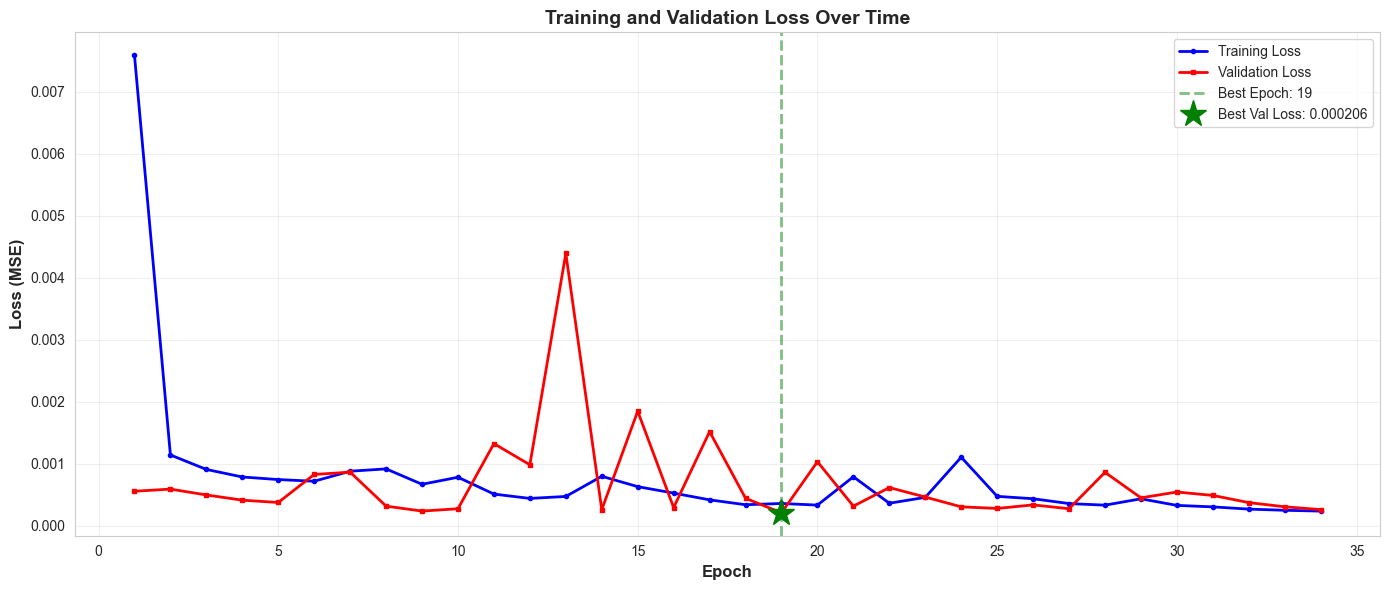


TRAINING ANALYSIS
Best epoch:           19/34
Best validation loss: 0.000206
Final train loss:     0.000234
Final val loss:       0.000259

✅ Model appears to be generalizing well


In [79]:
def plot_training_history(train_losses, val_losses):
    """Plot training and validation loss curves"""
    plt.figure(figsize=(14, 6))
    
    epochs = range(1, len(train_losses) + 1)
    
    plt.plot(epochs, train_losses, 'b-', label='Training Loss', linewidth=2, marker='o', markersize=3)
    plt.plot(epochs, val_losses, 'r-', label='Validation Loss', linewidth=2, marker='s', markersize=3)
    
    # Find best epoch
    best_epoch = np.argmin(val_losses) + 1
    best_val_loss = min(val_losses)
    
    plt.axvline(x=best_epoch, color='g', linestyle='--', alpha=0.5, linewidth=2,
                label=f'Best Epoch: {best_epoch}')
    plt.plot(best_epoch, best_val_loss, 'g*', markersize=20, label=f'Best Val Loss: {best_val_loss:.6f}')
    
    plt.xlabel('Epoch', fontsize=12, fontweight='bold')
    plt.ylabel('Loss (MSE)', fontsize=12, fontweight='bold')
    plt.title('Training and Validation Loss Over Time', fontsize=14, fontweight='bold')
    plt.legend(fontsize=10, loc='best')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    os.makedirs('../results', exist_ok=True)
    plt.savefig('../results/training_history.png', dpi=300, bbox_inches='tight')
    print(f"✓ Plot saved to: ../results/training_history.png")
    plt.show()
    
    # Analysis
    print(f"\n{'='*70}")
    print(f"TRAINING ANALYSIS")
    print(f"{'='*70}")
    print(f"Best epoch:           {best_epoch}/{len(train_losses)}")
    print(f"Best validation loss: {best_val_loss:.6f}")
    print(f"Final train loss:     {train_losses[-1]:.6f}")
    print(f"Final val loss:       {val_losses[-1]:.6f}")
    
    # Check for overfitting
    if train_losses[-1] < val_losses[-1] * 0.7:
        print(f"\n⚠️ Warning: Possible overfitting detected!")
        print(f"   Train loss is much lower than validation loss")
    else:
        print(f"\n✅ Model appears to be generalizing well")
    
    print(f"{'='*70}")

# Plot
plot_training_history(history['train_losses'], history['val_losses'])

In [80]:
# Save final model with complete metadata
metadata = {
    'lookback': lookback,
    'batch_size': batch_size,
    'learning_rate': learning_rate,
    'hidden_size': hidden_size,
    'num_layers': num_layers,
    'dropout': dropout,
    'best_val_loss': float(history['best_val_loss']),
    'final_train_loss': float(history['train_losses'][-1]),
    'epochs_trained': len(history['train_losses']),
    'training_time_minutes': round(training_time / 60, 2),
    'train_samples': len(X_train),
    'val_samples': len(X_val),
    'test_samples': len(X_test)
}

model.save_model(
    save_path='../models/saved_models/lstm_model',
    metadata=metadata
)

print("\n✅ Model and metadata saved successfully!")
print(f"   Model: ../models/saved_models/lstm_model.pth")
print(f"   Metadata: ../models/saved_models/lstm_model_metadata.json")

✓ Model saved to: ../models/saved_models/lstm_model.pth
✓ Metadata saved to: ../models/saved_models/lstm_model_metadata.json

✅ Model and metadata saved successfully!
   Model: ../models/saved_models/lstm_model.pth
   Metadata: ../models/saved_models/lstm_model_metadata.json


In [81]:
# Create experiment tracking
experiment_results = {
    'experiment_id': 1,
    'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'lookback': lookback,
    'batch_size': batch_size,
    'hidden_size': hidden_size,
    'num_layers': num_layers,
    'dropout': dropout,
    'learning_rate': learning_rate,
    'best_val_loss': history['best_val_loss'],
    'final_train_loss': history['train_losses'][-1],
    'epochs_trained': len(history['train_losses']),
    'training_time_min': round(training_time / 60, 2),
    'device': str(device)
}

# Save to CSV
os.makedirs('../results', exist_ok=True)
df_experiments = pd.DataFrame([experiment_results])

experiments_path = '../results/experiments.csv'
if os.path.exists(experiments_path):
    df_existing = pd.read_csv(experiments_path)
    df_experiments = pd.concat([df_existing, df_experiments], ignore_index=True)
    df_experiments['experiment_id'] = range(1, len(df_experiments) + 1)

df_experiments.to_csv(experiments_path, index=False)

print("✅ Experiment logged successfully!")
print(f"\n{df_experiments.tail(1)}")

✅ Experiment logged successfully!

   lookback  batch_size  hidden_size  num_layers  dropout  learning_rate  \
3        60          32           50           2      0.3           0.01   

   best_val_loss  final_train_loss  epochs_trained  training_time_minutes  \
3       0.000206          0.000234              34                    NaN   

             timestamp  experiment_id  training_time_min device  
3  2025-10-15 11:47:13              4               0.35   cuda  


## 🎯 Training Summary

### Model Configuration
- **Architecture:** LSTM with 2 layers
- **Lookback window:** 60 days
- **Hidden size:** 50 neurons
- **Dropout:** 0.2
- **Total parameters:** ~32,301

### Training Configuration
- **Batch size:** 32
- **Learning rate:** 0.001
- **Optimizer:** Adam
- **Loss function:** MSE
- **Early stopping:** 15 epochs patience

### Results
- **Best validation loss:** [Veja no output acima]
- **Epochs trained:** [Veja no output acima]
- **Training time:** [Veja no output acima] minutes

### Files Saved
- ✅ Model: `models/saved_models/lstm_model.pth`
- ✅ Metadata: `models/saved_models/lstm_model_metadata.json`
- ✅ Scaler: `models/saved_models/scaler.pkl`
- ✅ Checkpoint: `models/checkpoints/best_model.pth`
- ✅ Training plot: `results/training_history.png`
- ✅ Experiments log: `results/experiments.csv`

### Next Steps
1. ✅ Model trained successfully
2. 🔜 **Evaluate on test set** (Notebook 05)
3. 🔜 Calculate metrics (MAE, RMSE, MAPE)
4. 🔜 Visualize predictions
5. 🔜 Build API